## Threshold optimization using Performance metrics

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import xgboost as xgb

df = pd.read_csv("creditcard.csv")
y = df["Class"]
X = df.drop(["Class", "Amount", "Time"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
model_xgb = xgb.XGBClassifier(max_depth=5, scale_pos_weight=100)
model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[28429,     3],
       [    6,    43]])

In [2]:
y_pred = model_xgb.predict_proba(X_test)[:,1]
y_pred

array([1.0238165e-05, 1.4227397e-05, 5.2480987e-06, ..., 2.7707663e-06,
       1.6304925e-06, 8.0974127e-07], dtype=float32)

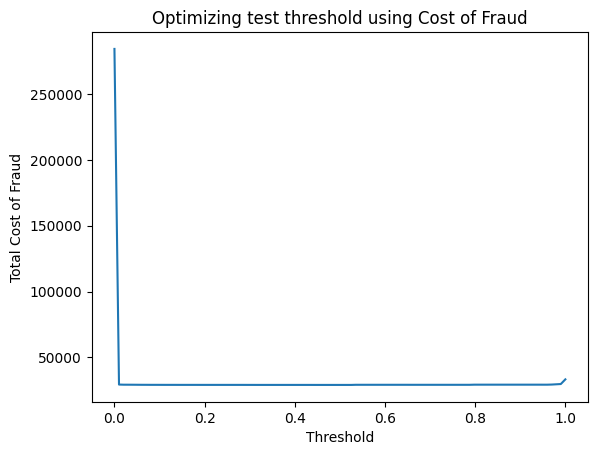

In [5]:
import numpy as np
from sklearn.metrics import average_precision_score

threshold_list = []
tcf_list = []
cost_tn=1
cost_fp=10
cost_fn=100
cost_tp=1
thresholds = np.linspace(0,1,100)

for threshold in thresholds:
    y_pred_thresh = [1 if e>threshold else 0 for e in y_pred]
    threshold_list.append(threshold)
    
    # Total cost of fraud
    conf_matrix_xgb = confusion_matrix(y_test, y_pred_thresh)
    tcf_score = (conf_matrix_xgb[0][0]*cost_tn) + (conf_matrix_xgb[0][1]*cost_fp) +\
                (conf_matrix_xgb[1][0]*cost_fn) + (conf_matrix_xgb[1][1]*cost_tp)
    tcf_list.append(tcf_score)
    
# plot curve
threshold_df = pd.DataFrame(threshold_list, tcf_list).reset_index()
threshold_df.columns = ["TCF", "Threshold"]

plt.plot(threshold_df["Threshold"], threshold_df["TCF"])
plt.title("Optimizing test threshold using Cost of Fraud")
plt.xlabel("Threshold")
plt.ylabel("Total Cost of Fraud")
plt.savefig("Optimizing threshold using Total Cost of Fraud");
plt.show()

In [6]:
threshold_df

,TCF,Threshold
0,284369,0.000000
1,29381,0.010101
2,29273,0.020202
3,29264,0.030303
4,29246,0.040404
...,...,...
95,29282,0.959596
96,29381,0.969697
97,29579,0.979798
98,29777,0.989899


In [8]:
# if threshold = 0, then everything is fraud (lots of false positives which cost 10$ each)
# if threshold = 1, then everything is non-fraudulent (quite few missed cases of fraud which cost 100$ each)
# Optimal threshold for this model is around 50% (already well balanced)
threshold_df.sort_values(by="TCF", ascending=True)

,TCF,Threshold
49,29102,0.494949
52,29102,0.525253
51,29102,0.515152
50,29102,0.505051
47,29102,0.474747
...,...,...
1,29381,0.010101
97,29579,0.979798
98,29777,0.989899
99,33332,1.000000


In [9]:
error_df = pd.DataFrame(y_pred, y_test).reset_index()
error_df.columns = ["Target variable", "Score"]
error_df.to_csv("error_df.csv")